In [ ]:
from pypots.data import load_specific_dataset
import tsdb

conf_pars = tsdb.utils.config.read_configs()
conf = {'path': {'data_home' : '/home/edfilatov'}}
tsdb.utils.config.write_configs(conf_pars, conf)

data = load_specific_dataset('physionet_2012')

2024-05-06 13:14:35 [INFO]: Wrote new configs to config.ini successfully.
2024-05-06 13:14:35 [INFO]: Loading the dataset physionet_2012 with TSDB (https://github.com/WenjieDu/Time_Series_Data_Beans)...
2024-05-06 13:14:35 [INFO]: Starting preprocessing physionet_2012...
2024-05-06 13:14:35 [INFO]: You're using dataset physionet_2012, please cite it properly in your work. You can find its reference information at the below link: 
https://github.com/WenjieDu/TSDB/tree/main/dataset_profiles/physionet_2012
2024-05-06 13:14:35 [INFO]: Dataset physionet_2012 has already been downloaded. Processing directly...
2024-05-06 13:14:35 [INFO]: Dataset physionet_2012 has already been cached. Loading from cache directly...
2024-05-06 13:14:35 [INFO]: Loaded successfully!


In [ ]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from pygrinder import mcar, mnar_t
from pypots.data import load_specific_dataset
from pypots.imputation import SAITS
from pypots.imputation import CSDI
from pypots.utils.metrics import calc_mae
from pypots.utils.metrics import calc_rmse
from pypots.utils.metrics import calc_mre
from pypots.utils.metrics import calc_quantile_crps
from scipy import stats

def calc_nlpd(y_pred, y_true, mask, y_pred_std):
    metric = (((y_true - y_pred)**2) * mask) / ((2 * y_pred_std**2) + 1e-12) + (np.log(y_pred_std + 1e-12) * mask) + 0.5 * np.log(2 * np.pi)

    return metric.sum() / (mask.sum() + 1e-12)

def calc_picp(y_pred, y_true, mask, y_pred_std, alpha=0.90):
    p_left, p_right = stats.norm.interval(confidence=alpha, loc=y_pred, scale=y_pred_std)
    metric = (y_true > p_left) * (y_true <= p_right)

    return (metric * mask).sum() / (mask.sum() + 1e-12)


In [ ]:
X = data['X']
num_samples = len(X['RecordID'].unique())
X = X.drop(['RecordID', 'Time'], axis = 1)
X = StandardScaler().fit_transform(X.to_numpy())
X = X.reshape(num_samples, 48, -1)
X_ori = X[:500, :, :]
X = X[500:5000, :, :]
X_ori_missed = mcar(X_ori, 0.1)  # randomly hold out 10% observed values as ground truth
dataset = {"X": X}  # X for model input
n_steps=X.shape[1]
n_features=X.shape[2]
print(X.shape)

(5000, 48, 37)


In [ ]:
data['X']

,RecordID,Time,ALP,ALT,AST,Albumin,BUN,Bilirubin,Cholesterol,Creatinine,...,RespRate,SaO2,SysABP,Temp,TroponinI,TroponinT,Urine,WBC,Weight,pH
0,132539,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,35.35,NaN,NaN,480.0,NaN,-1.0,NaN
1,132539,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,18.0,NaN,NaN,NaN,NaN,NaN,30.0,NaN,NaN,NaN
2,132539,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,19.0,NaN,NaN,NaN,NaN,NaN,170.0,NaN,NaN,NaN
3,132539,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,37.80,NaN,NaN,60.0,NaN,NaN,NaN
4,132539,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,20.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
575419,163037,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,122.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN
575420,163037,44.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
575421,163037,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,147.0,37.30,NaN,NaN,50.0,NaN,NaN,NaN
575422,163037,46.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,90.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
csdi = CSDI(n_features=n_features, n_layers=4, n_heads=8, n_channels=64, d_time_embedding=128, d_feature_embedding=128, d_diffusion_embedding=128, epochs=150, saving_path='csdi_model')#, optimizer=adam)

csdi.fit(dataset)

2024-05-06 13:15:40 [INFO]: No given device, using default device: cuda
2024-05-06 13:15:40 [INFO]: Model files will be saved to csdi_model/20240506_T131540
2024-05-06 13:15:40 [INFO]: Tensorboard file will be saved to csdi_model/20240506_T131540/tensorboard
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
2024-05-06 13:15:40 [INFO]: CSDI initialized with the given hyperparameters, the number of trainable parameters: 475,585
2024-05-06 13:16:31 [INFO]: Epoch 001 - training loss: 0.3943
2024-05-06 13:17:21 [INFO]: Epoch 002 - training loss: 0.3091
2024-05-06 13:18:07 [INFO]: Epoch 003 - training loss: 0.2993
2024-05-06 13:18:50 [INF

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.0001
csdi.epochs = 30
csdi.fit(dataset)

2024-05-06 15:05:24 [INFO]: Epoch 001 - training loss: 0.2113
2024-05-06 15:06:02 [INFO]: Epoch 002 - training loss: 0.2111
2024-05-06 15:06:40 [INFO]: Epoch 003 - training loss: 0.2207
2024-05-06 15:07:18 [INFO]: Epoch 004 - training loss: 0.2065
2024-05-06 15:07:56 [INFO]: Epoch 005 - training loss: 0.2106
2024-05-06 15:08:35 [INFO]: Epoch 006 - training loss: 0.2116
2024-05-06 15:09:13 [INFO]: Epoch 007 - training loss: 0.2150
2024-05-06 15:09:51 [INFO]: Epoch 008 - training loss: 0.2157
2024-05-06 15:10:29 [INFO]: Epoch 009 - training loss: 0.2131
2024-05-06 15:11:07 [INFO]: Epoch 010 - training loss: 0.2113
2024-05-06 15:11:46 [INFO]: Epoch 011 - training loss: 0.2157
2024-05-06 15:12:25 [INFO]: Epoch 012 - training loss: 0.2114
2024-05-06 15:13:04 [INFO]: Epoch 013 - training loss: 0.2180
2024-05-06 15:13:42 [INFO]: Epoch 014 - training loss: 0.2074
2024-05-06 15:14:22 [INFO]: Epoch 015 - training loss: 0.2116
2024-05-06 15:14:59 [INFO]: Epoch 016 - training loss: 0.2095
2024-05-

In [ ]:
csdi.optimizer.torch_optimizer.param_groups[0]['lr'] = 0.00001
csdi.epochs = 20
csdi.fit(dataset)

2024-05-06 15:24:41 [INFO]: Epoch 001 - training loss: 0.2080
2024-05-06 15:25:21 [INFO]: Epoch 002 - training loss: 0.2151
2024-05-06 15:26:01 [INFO]: Epoch 003 - training loss: 0.2128
2024-05-06 15:26:41 [INFO]: Epoch 004 - training loss: 0.2085
2024-05-06 15:27:22 [INFO]: Epoch 005 - training loss: 0.2153
2024-05-06 15:28:01 [INFO]: Epoch 006 - training loss: 0.2104
2024-05-06 15:28:41 [INFO]: Epoch 007 - training loss: 0.2036
2024-05-06 15:29:21 [INFO]: Epoch 008 - training loss: 0.2095
2024-05-06 15:30:02 [INFO]: Epoch 009 - training loss: 0.2136
2024-05-06 15:30:42 [INFO]: Epoch 010 - training loss: 0.2074
2024-05-06 15:31:22 [INFO]: Epoch 011 - training loss: 0.2155
2024-05-06 15:31:58 [INFO]: Epoch 012 - training loss: 0.2129
2024-05-06 15:32:34 [INFO]: Epoch 013 - training loss: 0.2067
2024-05-06 15:33:10 [INFO]: Epoch 014 - training loss: 0.2125
2024-05-06 15:33:45 [INFO]: Epoch 015 - training loss: 0.2141
2024-05-06 15:34:20 [INFO]: Epoch 016 - training loss: 0.2150
2024-05-

In [ ]:
%%time
n_preds = 30
imputation_csdi = csdi.predict(dataset, n_sampling_times=n_preds)  # impute the originally-missing values and artificially-missing values
indicating_mask = np.isnan(X_ori_missed) ^ np.isnan(X_ori)  # indicating mask for imputation error calculation

CPU times: user 2h 33min 59s, sys: 1h 9min 45s, total: 3h 43min 44s
Wall time: 4h 57min 49s


In [ ]:
mae_csdi = calc_mae(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_csdi = calc_rmse(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_csdi = calc_mre(np.median(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_csdi = calc_quantile_crps(imputation_csdi['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_csdi = calc_nlpd(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))
picp_csdi = calc_picp(np.mean(imputation_csdi['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_csdi['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi)

0.20363151897666468 0.4796888265502046 0.2924807445244592 0.5070604023180509 54.69642625919898 0.8831688435472163


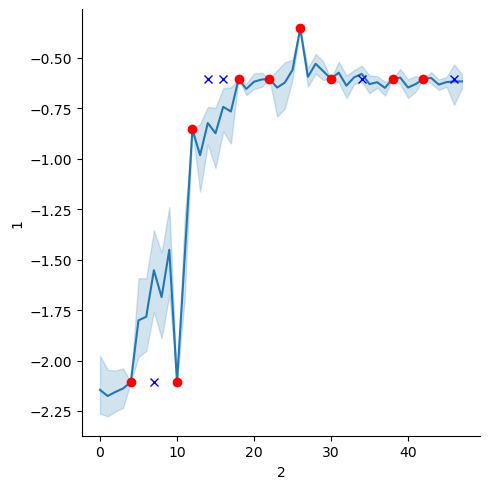

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

day = 132
station = 10

d = pd.DataFrame(columns=['1', '2'])
for i in range(n_preds):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
saits = SAITS(n_steps=n_steps, n_features=n_features, n_layers=2, d_model=256, d_inner=128, n_heads=4, d_k=64, d_v=64, dropout=0.1, epochs=200, saving_path='saits')
saits.fit(dataset)

2024-05-06 20:37:08 [INFO]: No given device, using default device: cuda
2024-05-06 20:37:08 [INFO]: Model files will be saved to saits/20240506_T203708
2024-05-06 20:37:08 [INFO]: Tensorboard file will be saved to saits/20240506_T203708/tensorboard
2024-05-06 20:37:09 [INFO]: SAITS initialized with the given hyperparameters, the number of trainable parameters: 1,378,358
2024-05-06 20:37:16 [INFO]: Epoch 001 - training loss: 0.8278
2024-05-06 20:37:18 [INFO]: Epoch 002 - training loss: 0.5792
2024-05-06 20:37:21 [INFO]: Epoch 003 - training loss: 0.5223
2024-05-06 20:37:27 [INFO]: Epoch 004 - training loss: 0.4880
2024-05-06 20:37:35 [INFO]: Epoch 005 - training loss: 0.4618
2024-05-06 20:37:43 [INFO]: Epoch 006 - training loss: 0.4354
2024-05-06 20:37:51 [INFO]: Epoch 007 - training loss: 0.4146
2024-05-06 20:38:00 [INFO]: Epoch 008 - training loss: 0.3973
2024-05-06 20:38:08 [INFO]: Epoch 009 - training loss: 0.3865
2024-05-06 20:38:16 [INFO]: Epoch 010 - training loss: 0.3784
2024-05

In [ ]:
imputation_saits = saits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_saits = calc_mae(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_saits = calc_rmse(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_saits = calc_mre(imputation_saits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_saits = calc_quantile_crps(np.expand_dims(imputation_saits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_saits, rmse_saits, mape_saits, crps_saits)

0.21370081404210337 0.4809695887626816 0.3069435100745873 0.3069434918855366


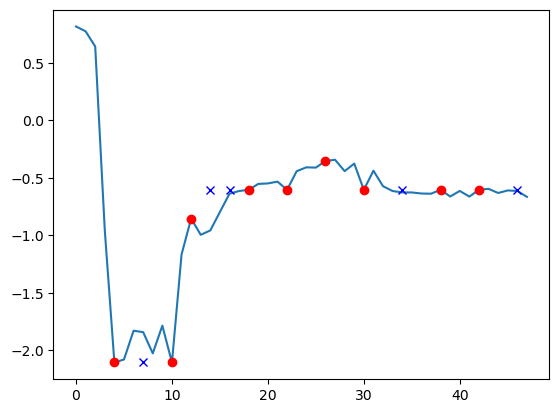

In [ ]:
plt.plot(imputation_saits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import BRITS

brits = BRITS(n_steps=n_steps, n_features=n_features, rnn_hidden_size=128, epochs=100, saving_path='brits')
brits.fit(dataset)

2024-05-06 21:04:57 [INFO]: No given device, using default device: cuda
2024-05-06 21:04:57 [INFO]: Model files will be saved to brits/20240506_T210457
2024-05-06 21:04:57 [INFO]: Tensorboard file will be saved to brits/20240506_T210457/tensorboard
2024-05-06 21:04:57 [INFO]: BRITS initialized with the given hyperparameters, the number of trainable parameters: 239,344
2024-05-06 21:10:31 [INFO]: Epoch 001 - training loss: 1.0398
2024-05-06 21:15:44 [INFO]: Epoch 002 - training loss: 0.8128
2024-05-06 21:20:57 [INFO]: Epoch 003 - training loss: 0.7476
2024-05-06 21:26:09 [INFO]: Epoch 004 - training loss: 0.7136
2024-05-06 21:31:21 [INFO]: Epoch 005 - training loss: 0.6935
2024-05-06 21:36:35 [INFO]: Epoch 006 - training loss: 0.6806
2024-05-06 21:41:53 [INFO]: Epoch 007 - training loss: 0.6716
2024-05-06 21:47:18 [INFO]: Epoch 008 - training loss: 0.6632
2024-05-06 21:52:35 [INFO]: Epoch 009 - training loss: 0.6576
2024-05-06 21:57:55 [INFO]: Epoch 010 - training loss: 0.6531
2024-05-0

In [ ]:
imputation_brits = brits.predict(dataset)  # impute the originally-missing values and artificially-missing values
mae_brits = calc_mae(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
rmse_brits = calc_rmse(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
mape_brits = calc_mre(imputation_brits['imputation'], np.nan_to_num(X_ori), indicating_mask)
crps_brits = calc_quantile_crps(np.expand_dims(imputation_brits['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)

In [ ]:
print(mae_brits, rmse_brits, mape_brits, crps_brits)

0.2312972962569353 0.5457307274528826 0.33221775172965856 0.33221771842555


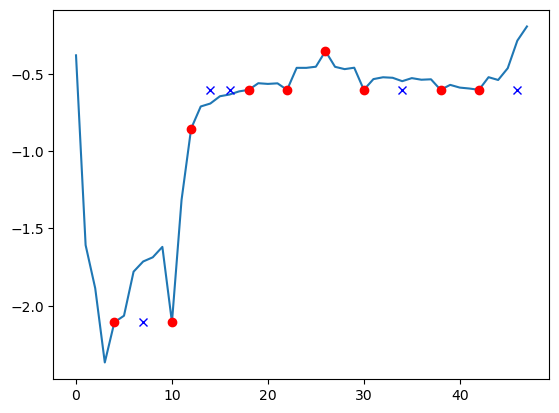

In [ ]:
plt.plot(imputation_brits['imputation'][day][:, station])
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
from pypots.imputation import GPVAE

gp_vae = GPVAE(n_steps=n_steps, n_features=n_features, latent_size=256, epochs=200, encoder_sizes=(256, 256), decoder_sizes=(256, 256), saving_path='gp_vae')
gp_vae.fit(dataset)

2024-05-07 00:59:37 [INFO]: No given device, using default device: cuda
2024-05-07 00:59:37 [INFO]: Model files will be saved to gp_vae/20240507_T005937
2024-05-07 00:59:37 [INFO]: Tensorboard file will be saved to gp_vae/20240507_T005937/tensorboard
2024-05-07 00:59:37 [INFO]: GPVAE initialized with the given hyperparameters, the number of trainable parameters: 432,933
2024-05-07 01:00:16 [INFO]: Epoch 001 - training loss: 182456.2295
2024-05-07 01:00:48 [INFO]: Epoch 002 - training loss: 155442.0079
2024-05-07 01:01:11 [INFO]: Epoch 003 - training loss: 155398.0215
2024-05-07 01:01:28 [INFO]: Epoch 004 - training loss: 155374.1429
2024-05-07 01:01:47 [INFO]: Epoch 005 - training loss: 155367.4884
2024-05-07 01:02:07 [INFO]: Epoch 006 - training loss: 155358.9844
2024-05-07 01:02:27 [INFO]: Epoch 007 - training loss: 155355.8318
2024-05-07 01:02:53 [INFO]: Epoch 008 - training loss: 155353.8202
2024-05-07 01:03:20 [INFO]: Epoch 009 - training loss: 155355.9088
2024-05-07 01:03:46 [INF

In [ ]:
imputation_gp_vae = gp_vae.predict(dataset, n_sampling_times=3)  # impute the originally-missing values and artificially-missing values
mae_gp_vae = calc_mae(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
rmse_gp_vae = calc_rmse(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
mape_gp_vae = calc_mre(np.median(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask)
crps_gp_vae = calc_quantile_crps(imputation_gp_vae['imputation'], np.nan_to_num(X_ori), indicating_mask)
nlpd_gp_vae = calc_nlpd(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))
picp_gp_vae = calc_picp(np.mean(imputation_gp_vae['imputation'], axis=1), np.nan_to_num(X_ori), indicating_mask, np.std(imputation_gp_vae['imputation'], axis=1))

/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2241: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/edfilatov/.conda/envs/pypots/lib/python3.11/site-packages/scipy/stats/_distn_infrastructure.py:2242: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


In [ ]:
print(mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae)

0.6006994356008081 0.8634548461628958 0.8627987407984736 0.8627986907958984 745387560631.6647 0.0


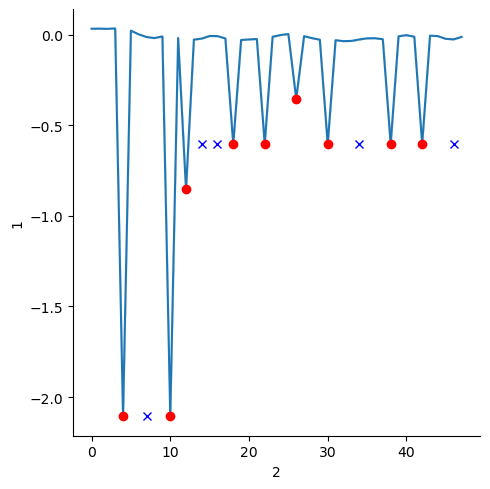

In [ ]:
d = pd.DataFrame(columns=['1', '2'])
for i in range(3):
    for j in range(n_steps):
        d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
sns.relplot(data=d, y = '1', x='2', kind='line')
for i, marker in enumerate(indicating_mask[day, :, station]):
    plt.plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

In [ ]:
np.save('imputation_csdi_physio_2', imputation_csdi['imputation'])
np.save('imputation_saits_physio_2', imputation_saits['imputation'])
np.save('imputation_brits_physio_2', imputation_brits['imputation'])
np.save('imputation_gp_vae_physio_2', imputation_gp_vae['imputation'])

In [ ]:
pd.DataFrame([[mae_csdi, rmse_csdi, mape_csdi, crps_csdi, nlpd_csdi, picp_csdi],
             [mae_saits, rmse_saits, mape_saits, crps_saits, -1, -1],
             [mae_brits, rmse_brits, mape_brits, crps_brits, -1, -1],
             [mae_gp_vae, rmse_gp_vae, mape_gp_vae, crps_gp_vae, nlpd_gp_vae, picp_gp_vae]], index=['CSDI', 'SAITS', 'BRITS', 'GP VAE'], columns=['MAE', 'RMSE', 'MAPE', 'CRPS', 'NLPD', 'PICP'])

,MAE,RMSE,MAPE,CRPS,NLPD,PICP
CSDI,0.203632,0.479689,0.292481,0.507060,5.469643e+01,0.883169
SAITS,0.213701,0.480970,0.306944,0.306943,-1.000000e+00,-1.000000
BRITS,0.231297,0.545731,0.332218,0.332218,-1.000000e+00,-1.000000
GP VAE,0.600699,0.863455,0.862799,0.862799,7.453876e+11,0.000000


In [ ]:
days = np.random.randint(500, size=10)
stations = np.random.randint(37, size=10)

<Figure size 2000x2000 with 0 Axes>

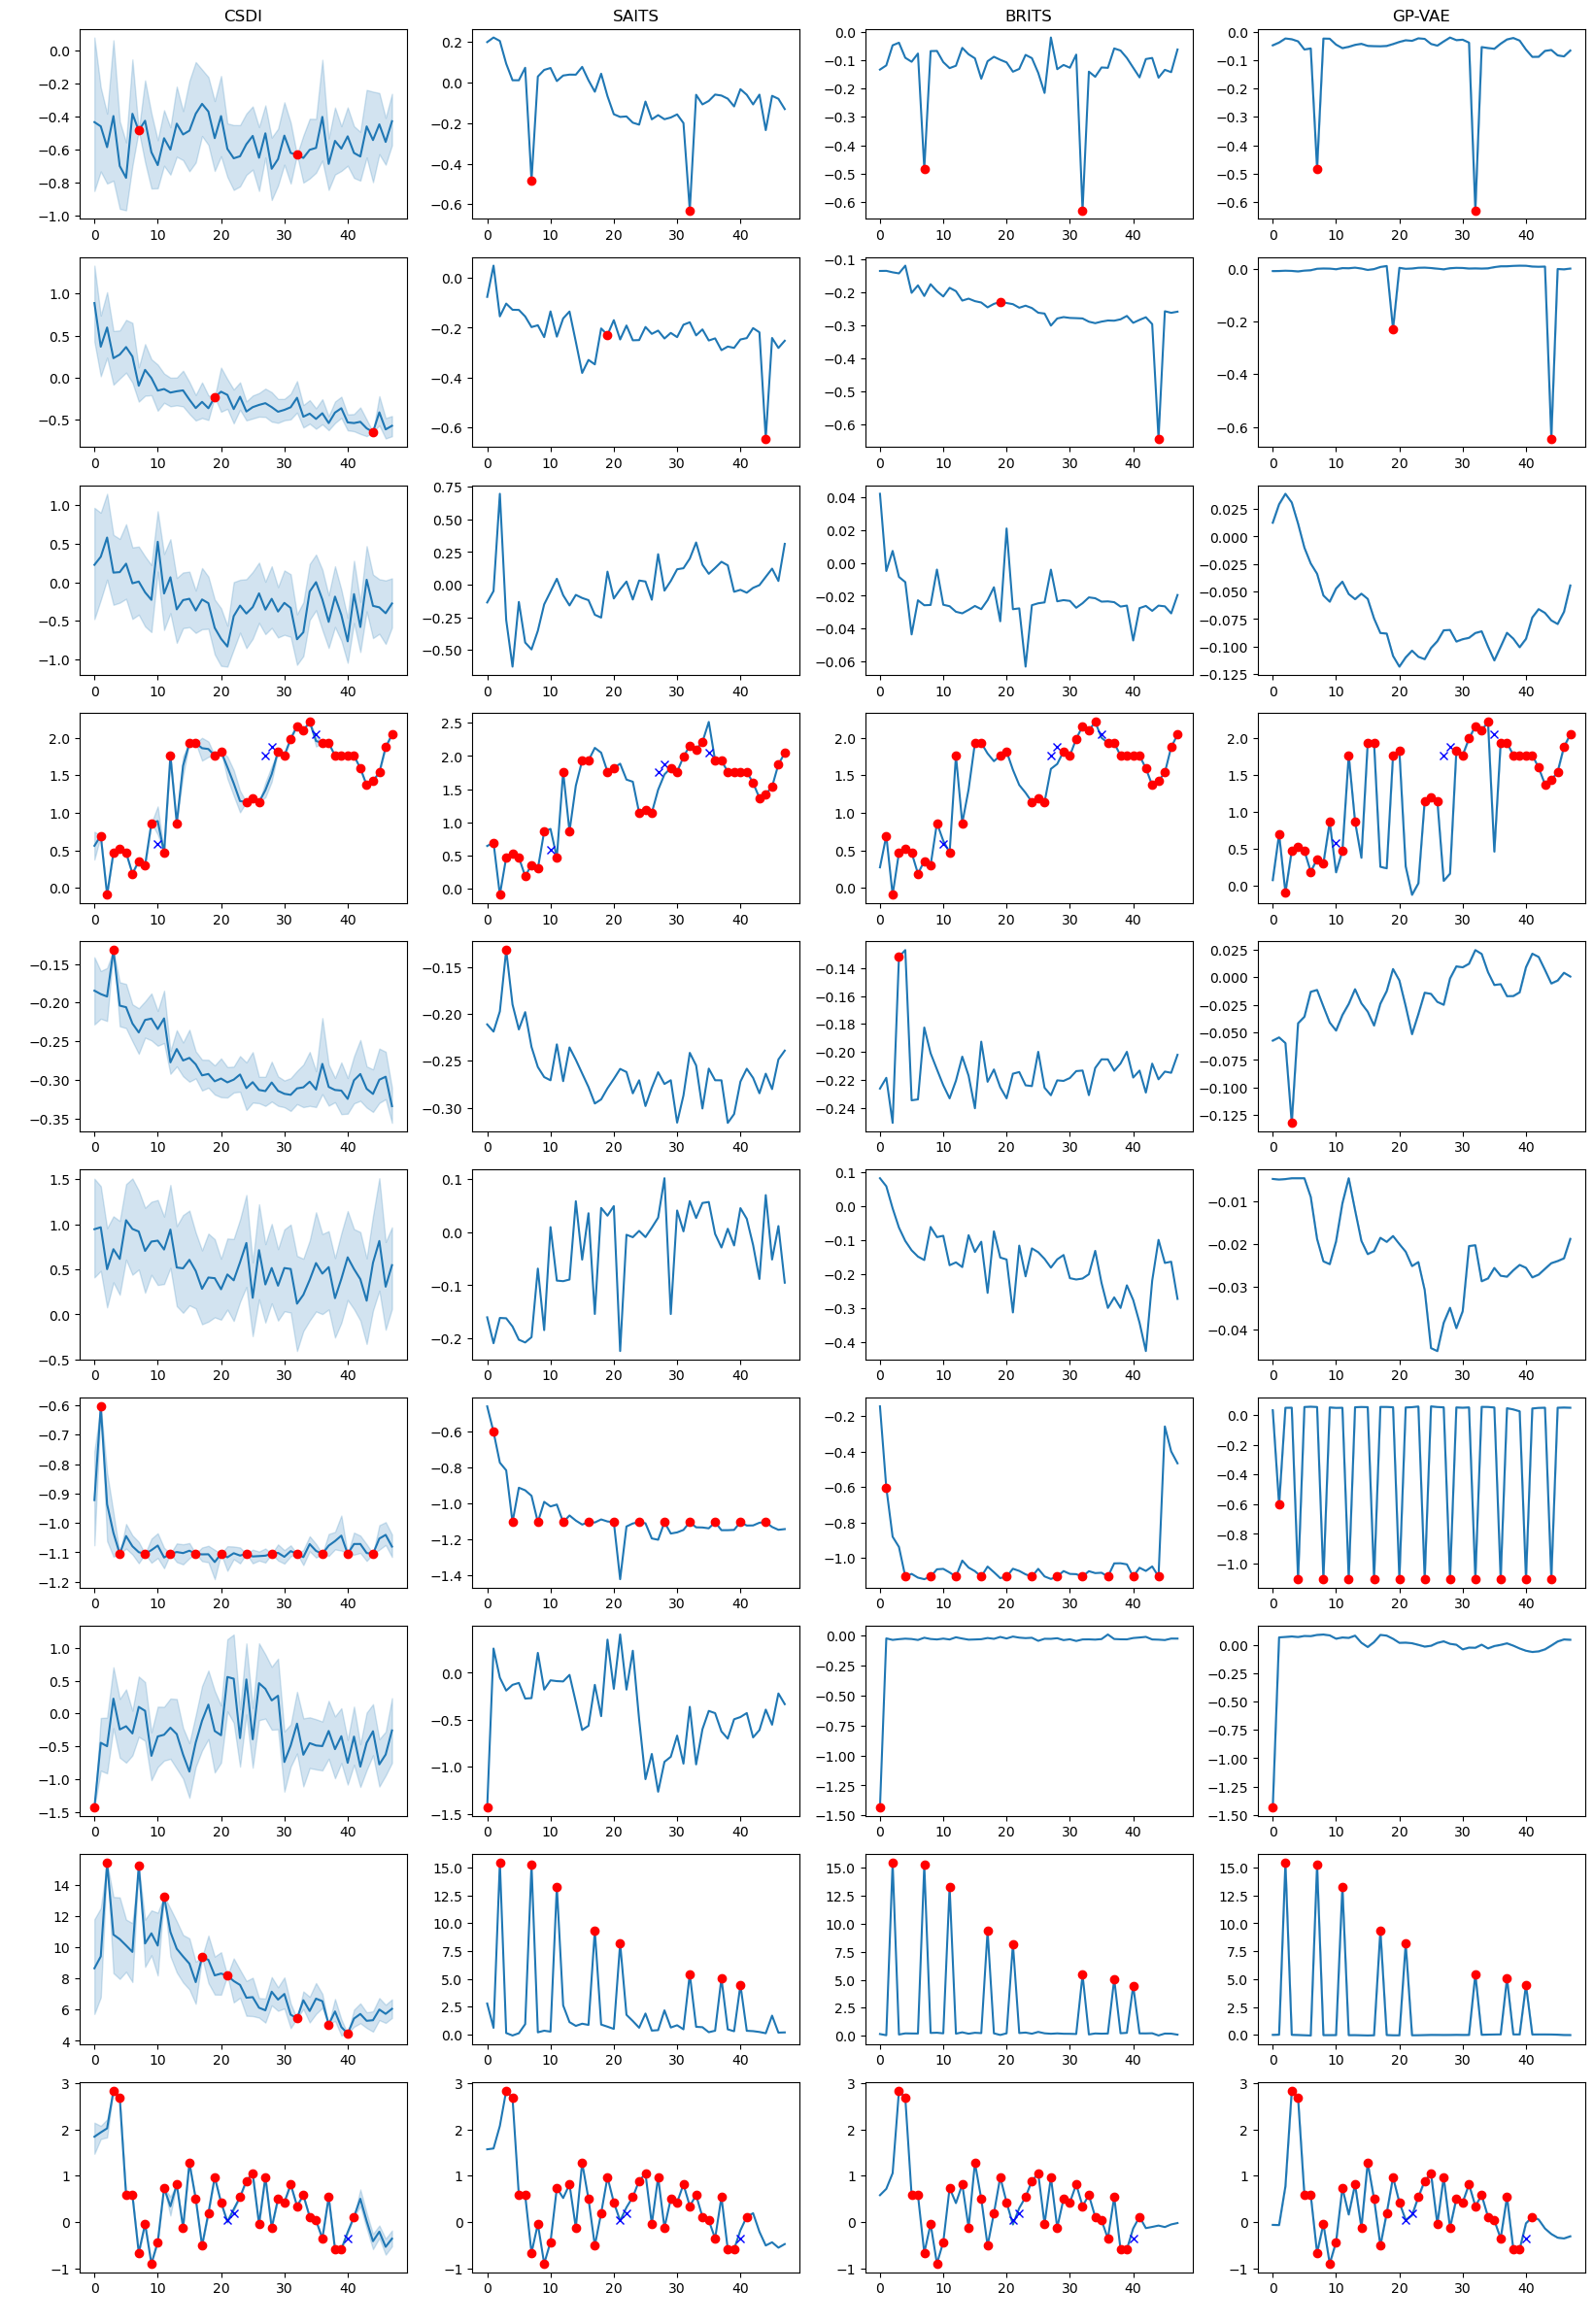

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (20, 20))
fig, ax = plt.subplots(10, 4)
fig.set_figheight(30)
fig.set_figwidth(20)

ax[0][0].set_title('CSDI')
ax[0][1].set_title('SAITS')
ax[0][2].set_title('BRITS')
ax[0][3].set_title('GP-VAE')

for ids, day_station in enumerate(zip(days, stations)):
    day = day_station[0]
    station = day_station[1]
    n_preds = 30

    ax[ids][0].set_xlabel(' ')
    ax[ids][1].set_xlabel(' ')
    ax[ids][2].set_xlabel(' ')
    ax[ids][3].set_xlabel(' ')
    ax[ids][0].set_ylabel(' ')
    ax[ids][1].set_ylabel(' ')
    ax[ids][2].set_ylabel(' ')
    ax[ids][3].set_ylabel(' ')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(n_preds):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_csdi['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 0])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 0].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 1].plot(imputation_saits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 1].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    ax[ids, 2].plot(imputation_brits['imputation'][day][:, station])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 2].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')

    d = pd.DataFrame(columns=['1', '2'])
    for i in range(3):
        for j in range(n_steps):
            d = pd.concat([d, pd.DataFrame([{'1': imputation_gp_vae['imputation'][day, i, j, station], '2' : j}])], ignore_index=True)
    sns.lineplot(data=d, y = '1', x='2', ax=ax[ids, 3])
    for i, marker in enumerate(indicating_mask[day, :, station]):
        ax[ids, 3].plot(i, X_ori[day, i, station], 'bx' if marker else 'ro')